   Method      Node  PathCount    AvgHop
0       L   node[0]      17833  1.022542
1       L   node[2]        916  1.012009
2       L   node[3]      17923  1.026670
3       L  node[13]      19387  1.053954
4       L  node[14]      17504  1.015197
5       L  node[16]      18248  1.032552
6       L  node[18]      18355  1.020975
7       L  node[24]      18765  1.034959
8       L  node[29]      18239  1.027688
9       P   node[0]      17036  1.015027
10      P   node[2]      16964  1.011731
11      P   node[3]      18056  1.037605
12      P  node[13]      17802  1.030783
13      P  node[14]      16868  1.010138
14      P  node[16]      17229  1.024668
15      P  node[18]      17295  1.019659
16      P  node[24]      18233  1.043547
17      P  node[29]      17655  1.027471


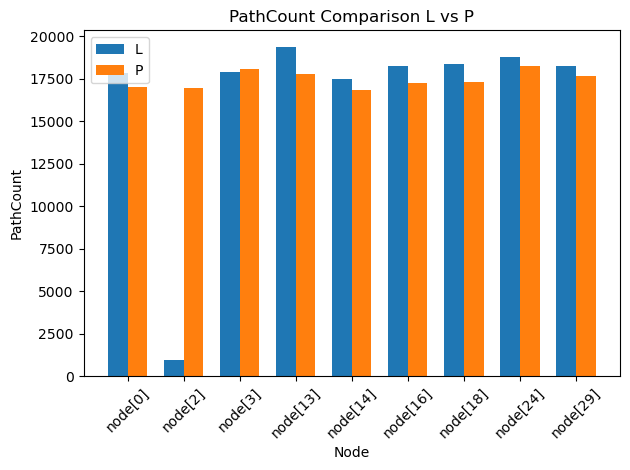

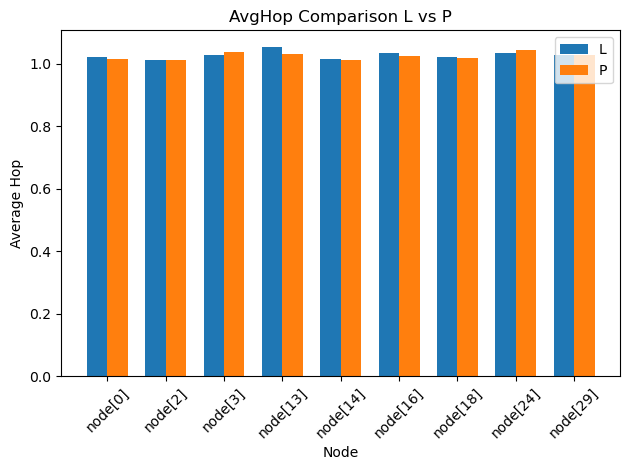

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

result = []

for method in methods:
    for node_folder in nodes:
        node_num = node_folder[1:]
        target_node = f"node[{node_num}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()
        
        df = df.sort_values(by=['Time'])

        prev = {}
        path_count = 0
        hop_counts = []

        for t in df['Time'].dropna().unique():
            df_t = df[df['Time'] == t]
            for dest in df_t['Destination'].unique():
                df_dest = df_t[df_t['Destination'] == dest]
                if df_dest.empty:
                    continue
                row = df_dest.iloc[0]
                key = dest
                current = (
                    row['NextHop'],
                    row['Metric'],
                    row['Lifetime'],
                    row['DestSeq']
                )
                if key not in prev or prev[key] != current:
                    prev[key] = current
                    path_count += 1
                    hop_counts.append(row['Metric'])

        avg_hop = sum(hop_counts) / len(hop_counts) if hop_counts else 0

        result.append({
            "Method": method,
            "Node": target_node,
            "PathCount": path_count,
            "AvgHop": avg_hop
        })

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

avghop_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]
avghop_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("PathCount Comparison L vs P")
plt.ylabel("PathCount")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar([i - width/2 for i in x], avghop_L, width=width, label="L")
plt.bar([i + width/2 for i in x], avghop_P, width=width, label="P")
plt.title("AvgHop Comparison L vs P")
plt.ylabel("Average Hop")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

result = []

for method in methods:
    for node_folder in nodes:
        node_num = node_folder[1:]
        target_node = f"node[{node_num}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()
        
        path_set = set()
        hop_counts = []

        for t in sorted(df['Time'].dropna().unique()):
            df_t = df[df['Time'] == t]
            G = nx.DiGraph()
            for _, row in df_t.iterrows():
                src = row['Node']
                dst = row['NextHop']
                if src != dst:
                    G.add_edge(src, dst)
            if 'rsu[0]' in G and target_node in G:
                try:
                    for path in nx.all_simple_paths(G, source='rsu[0]', target=target_node):
                        path_str = " → ".join(path)
                        if path_str not in path_set:
                            path_set.add(path_str)
                            hop_counts.append(len(path) - 1)
                except nx.NetworkXNoPath:
                    continue

        avg_hop = sum(hop_counts) / len(hop_counts) if hop_counts else 0

        result.append({
            "Method": method,
            "Node": target_node,
            "PathCount": len(path_set),
            "AvgHop": avg_hop
        })

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

avghop_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]
avghop_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Unique Path Count Comparison L vs P")
plt.ylabel("Unique Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar([i - width/2 for i in x], avghop_L, width=width, label="L")
plt.bar([i + width/2 for i in x], avghop_P, width=width, label="P")
plt.title("Average Hop Count of Unique Paths L vs P")
plt.ylabel("Average Hop")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [4]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

result = []

for method in methods:
    print(f"Start Method: {method}")
    for node_folder in nodes:
        print(f"  Start Node: {node_folder}")
        
        node_num = node_folder[1:]
        target_node = f"node[{node_num}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        
        if not os.path.exists(file_path):
            print(f"    File not found: {file_path}")
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()
        
        path_set = set()
        hop_counts = []

        times = sorted(df['Time'].dropna().unique())
        print(f"    Time snapshots: {len(times)}")

        for t_idx, t in enumerate(times):
            print(f"      Processing time {t} ({t_idx+1}/{len(times)})")
            df_t = df[df['Time'] == t]
            G = nx.DiGraph()
            for _, row in df_t.iterrows():
                src = row['Node']
                dst = row['NextHop']
                if src != dst:
                    G.add_edge(src, dst)

            if 'rsu[0]' in G and target_node in G:
                try:
                    path_count_this = 0
                    for path in nx.all_simple_paths(G, source='rsu[0]', target=target_node):
                        path_str = " → ".join(path)
                        if path_str not in path_set:
                            path_set.add(path_str)
                            hop_counts.append(len(path) - 1)
                            path_count_this += 1
                    print(f"        Found {path_count_this} new unique paths at time {t}")
                except nx.NetworkXNoPath:
                    print(f"        No path at time {t}")
                    continue

        avg_hop = sum(hop_counts) / len(hop_counts) if hop_counts else 0

        result.append({
            "Method": method,
            "Node": target_node,
            "PathCount": len(path_set),
            "AvgHop": avg_hop
        })
        print(f"  Done Node: {node_folder} PathCount={len(path_set)} AvgHop={avg_hop}")
    print(f"Done Method: {method}")

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

avghop_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]
avghop_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Unique Path Count Comparison L vs P")
plt.ylabel("Unique Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar([i - width/2 for i in x], avghop_L, width=width, label="L")
plt.bar([i + width/2 for i in x], avghop_P, width=width, label="P")
plt.title("Average Hop Count of Unique Paths L vs P")
plt.ylabel("Average Hop")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Start Method: L
  Start Node: N0
    Time snapshots: 70
      Processing time 31 (1/70)
      Processing time 32 (2/70)
      Processing time 33 (3/70)
      Processing time 34 (4/70)
      Processing time 35 (5/70)


KeyboardInterrupt: 

In [18]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
import sys

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

result = []

for method in methods:
    print(f"Start Method: {method}")
    for node_folder in nodes:
        print(f"  Start Node: {node_folder}")
        
        node_num = node_folder[1:]
        target_node = f"node[{node_num}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        
        if not os.path.exists(file_path):
            print(f"    File not found: {file_path}")
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()
        
        path_set = set()
        hop_counts = []

        times = sorted(df['Time'].dropna().unique())
        print(f"    Time snapshots: {len(times)}")

        for t_idx, t in enumerate(times):
            start_time = time.time()
            print(f"      Processing time {t} ({t_idx+1}/{len(times)})")
            df_t = df[df['Time'] == t]
            G = nx.DiGraph()
            for _, row in df_t.iterrows():
                src = row['Node']
                dst = row['NextHop']
                if src != dst:
                    G.add_edge(src, dst)

            if 'rsu[0]' in G and target_node in G:
                try:
                    gen = nx.all_simple_paths(G, source='rsu[0]', target=target_node, cutoff=35)
                    total = 0
                    for path in gen:
                        total += 1
                        path_str = " → ".join(path)
                        if path_str not in path_set:
                            path_set.add(path_str)
                            hop_counts.append(len(path) - 1)
                        if total % 1000 == 0:
                            sys.stdout.write(f"\r        Paths generated: {total}")
                            sys.stdout.flush()
                    sys.stdout.write(f"\r        Paths generated: {total}\n")
                except nx.NetworkXNoPath:
                    print(f"        No path at time {t}")
                    continue
            else:
                print(f"        rsu[0] or {target_node} not in graph at time {t}")
            duration = time.time() - start_time
            print(f"      Time {t} done in {duration:.2f} sec")

        avg_hop = sum(hop_counts) / len(hop_counts) if hop_counts else 0

        result.append({
            "Method": method,
            "Node": target_node,
            "PathCount": len(path_set),
            "AvgHop": avg_hop
        })
        print(f"  Done Node: {node_folder} PathCount={len(path_set)} AvgHop={avg_hop}")
    print(f"Done Method: {method}")

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

avghop_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]
avghop_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Unique Path Count Comparison L vs P")
plt.ylabel("Unique Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar([i - width/2 for i in x], avghop_L, width=width, label="L")
plt.bar([i + width/2 for i in x], avghop_P, width=width, label="P")
plt.title("Average Hop Count of Unique Paths L vs P")
plt.ylabel("Average Hop")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Start Method: L
  Start Node: N0
    Time snapshots: 70
      Processing time 31 (1/70)
        rsu[0] or node[0] not in graph at time 31
      Time 31 done in 0.05 sec
      Processing time 32 (2/70)
        rsu[0] or node[0] not in graph at time 32
      Time 32 done in 0.09 sec
      Processing time 33 (3/70)
        rsu[0] or node[0] not in graph at time 33
      Time 33 done in 0.10 sec
      Processing time 34 (4/70)
        rsu[0] or node[0] not in graph at time 34
      Time 34 done in 0.10 sec
      Processing time 35 (5/70)
        Paths generated: 65170000

MemoryError: 

In [1]:
import os
import sys
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

def custom_dfs_paths(G, source, target, max_hop):
    stack = [(source, [source])]
    while stack:
        node, path = stack.pop()
        if len(path) > max_hop + 1:
            continue
        for neighbor in G.neighbors(node):
            if neighbor in path:
                continue
            new_path = path + [neighbor]
            if neighbor == target:
                yield new_path
            else:
                stack.append((neighbor, new_path))

result = []
log_lines = []

for method in methods:
    print(f"Start Method: {method}")
    for node_folder in nodes:
        target_node = f"node[{node_folder[1:]}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        if not os.path.exists(file_path):
            print(f"  File not found: {file_path}")
            result.append({"Method": method, "Node": target_node, "PathCount": 0})
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()

        times = sorted(df['Time'].dropna().unique())
        total_path_count = 0

        for idx, t in enumerate(times, 1):
            start_time = time.time()
            df_t = df[df['Time'] == t]
            G = nx.DiGraph()
            for _, row in df_t.iterrows():
                src = row['Node']
                dst = row['NextHop']
                if src != dst:
                    G.add_edge(src, dst)

            if 'rsu[0]' in G and target_node in G:
                path_count = 0
                for path in custom_dfs_paths(G, 'rsu[0]', target_node, 35):
                    path_count += 1
                    if path_count % 1000 == 0:
                        sys.stdout.write(f"\r  {method} {target_node} time {t}: {path_count} paths")
                        sys.stdout.flush()
                sys.stdout.write(f"\r  {method} {target_node} time {t}: {path_count} total paths\n")
                sys.stdout.flush()

                total_path_count += path_count
                log_lines.append(f"{method},{target_node},{t},{path_count},{round(time.time() - start_time, 2)}")
            else:
                sys.stdout.write(f"  {method} {target_node} time {t}: no path\n")
                sys.stdout.flush()

        result.append({"Method": method, "Node": target_node, "PathCount": total_path_count})
        print(f"  Done {method} {target_node}: PathCount={total_path_count}")

with open("path_summary_log.csv", "w", encoding="utf-8") as f:
    f.write("Method,Node,Time,PathCount,DurationSec\n")
    for line in log_lines:
        f.write(line + "\n")

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Unique Path Count Comparison L vs P")
plt.ylabel("Unique Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Start Method: L
  L node[0] time 31: no path
  L node[0] time 32: no path
  L node[0] time 33: no path
  L node[0] time 34: no path
  L node[0] time 35: 121000 paths

KeyboardInterrupt: 

In [ ]:
import os
import sys
import time
import pandas as pd
import networkx as nx
import ray
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

def custom_dfs_paths(G, source, target, max_hop):
    stack = [(source, [source])]
    while stack:
        node, path = stack.pop()
        if len(path) > max_hop + 1:
            continue
        for neighbor in G.neighbors(node):
            if neighbor in path:
                continue
            new_path = path + [neighbor]
            if neighbor == target:
                yield new_path
            else:
                stack.append((neighbor, new_path))

@ray.remote
def process_node_method(method, node_folder):
    target_node = f"node[{node_folder[1:]}]"
    file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
    if not os.path.exists(file_path):
        return {"Method": method, "Node": target_node, "PathCount": 0}

    df = pd.read_csv(file_path, header=None, skiprows=1)
    df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['Node'] = df['Node'].astype(str).str.strip()
    df['NextHop'] = df['NextHop'].astype(str).str.strip()

    times = sorted(df['Time'].dropna().unique())
    total_path_count = 0
    log_lines = []

    for t in times:
        start_time = time.time()
        df_t = df[df['Time'] == t]
        G = nx.DiGraph()
        for _, row in df_t.iterrows():
            src = row['Node']
            dst = row['NextHop']
            if src != dst:
                G.add_edge(src, dst)

        if 'rsu[0]' in G and target_node in G:
            path_count = 0
            for path in custom_dfs_paths(G, 'rsu[0]', target_node, 35):
                path_count += 1
                if path_count % 1000 == 0:
                    sys.stdout.write(f"\r{method} {target_node} time {t}: {path_count} paths")
                    sys.stdout.flush()
            sys.stdout.write(f"\r{method} {target_node} time {t}: {path_count} total paths\n")
            sys.stdout.flush()

            total_path_count += path_count
            log_lines.append(f"{method},{target_node},{t},{path_count},{round(time.time() - start_time, 2)}")
        else:
            sys.stdout.write(f"{method} {target_node} time {t}: no path\n")
            sys.stdout.flush()

    with open(f"path_summary_{method}_{node_folder}.csv", "w", encoding="utf-8") as f:
        f.write("Method,Node,Time,PathCount,DurationSec\n")
        for line in log_lines:
            f.write(line + "\n")

    return {"Method": method, "Node": target_node, "PathCount": total_path_count}

ray.init(include_dashboard=False)

tasks = [process_node_method.remote(method, node) for method in methods for node in nodes]
results = ray.get(tasks)

df_result = pd.DataFrame(results)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Path Count Comparison L vs P")
plt.ylabel("Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted)
plt.legend()
plt.tight_layout()
plt.show()


2025-06-26 17:28:06,457	ERROR services.py:1355 -- Failed to start the dashboard , return code 3221226505
2025-06-26 17:28:06,458	ERROR services.py:1380 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2025-06-26 17:28:06,459	ERROR services.py:1424 -- 
The last 20 lines of C:\Users\CHOEJO~1\AppData\Local\Temp\ray\session_2025-06-26_17-28-05_092286_55516\logs\dashboard.log (it contains the error message from the dashboard): 
Traceback (most recent call last):
  File "c:\Conda\Lib\site-packages\ray\dashboard\dashboard.py", line 246, in <module>
    logging_utils.redirect_stdout_stderr_if_needed(
  File "c:\Conda\Lib\site-packages\ray\_private\logging_utils.py", line 49, in redirect_stdout_stderr_if_needed
    sys.stderr = open_log(stderr_fileno, unbuffered=True, closefd=False)
       

In [17]:
import os
import sys
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

def custom_dfs_paths(G, source, target, max_hop):
    stack = [(source, [source])]
    while stack:
        node, path = stack.pop()
        if len(path) > max_hop + 1:
            continue
        for neighbor in G.neighbors(node):
            if neighbor in path:
                continue
            new_path = path + [neighbor]
            if neighbor == target:
                yield new_path
            else:
                stack.append((neighbor, new_path))

result = []
log_lines = []

for method in methods:
    print(f"Start Method: {method}")
    for node_folder in nodes:
        target_node = f"node[{node_folder[1:]}]"
        file_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
        if not os.path.exists(file_path):
            print(f"  File not found: {file_path}")
            result.append({"Method": method, "Node": target_node, "PathCount": 0, "AvgHop": 0})
            continue

        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.columns = ['Time', 'Node', 'Destination', 'NextHop', 'Metric', 'Lifetime', 'DestSeq']
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df['Node'] = df['Node'].astype(str).str.strip()
        df['NextHop'] = df['NextHop'].astype(str).str.strip()

        times = sorted(df['Time'].dropna().unique())
        hop_counts = []

        for idx, t in enumerate(times, 1):
            start_time = time.time()
            df_t = df[df['Time'] == t]
            G = nx.DiGraph()
            for _, row in df_t.iterrows():
                src = row['Node']
                dst = row['NextHop']
                if src != dst:
                    G.add_edge(src, dst)

            if 'rsu[0]' in G and target_node in G:
                path_count = 0
                for path in custom_dfs_paths(G, 'rsu[0]', target_node, 35):
                    hop_counts.append(len(path) - 1)
                    path_count += 1
                    if path_count % 1000 == 0:
                        sys.stdout.write(f"\r  {method} {target_node} time {t}: {path_count} paths")
                        sys.stdout.flush()
                sys.stdout.write(f"\r  {method} {target_node} time {t}: {path_count} total paths\n")
                sys.stdout.flush()

                log_lines.append(f"{method},{target_node},{t},{path_count},{round(time.time() - start_time, 2)}")
            else:
                sys.stdout.write(f"  {method} {target_node} time {t}: no path\n")
                sys.stdout.flush()

        avg_hop = sum(hop_counts) / len(hop_counts) if hop_counts else 0
        result.append({"Method": method, "Node": target_node, "PathCount": len(hop_counts), "AvgHop": avg_hop})
        print(f"  Done {method} {target_node}: PathCount={len(hop_counts)}, AvgHop={avg_hop}")

with open("path_summary_log.csv", "w", encoding="utf-8") as f:
    f.write("Method,Node,Time,PathCount,DurationSec\n")
    for line in log_lines:
        f.write(line + "\n")

df_result = pd.DataFrame(result)
print(df_result)

nodes_sorted = [f"node[{n[1:]}]" for n in nodes]
x = range(len(nodes_sorted))
width = 0.35

pathcount_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]
pathcount_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["PathCount"]

avghop_L = df_result[df_result["Method"] == "L"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]
avghop_P = df_result[df_result["Method"] == "P"].set_index("Node").reindex(nodes_sorted, fill_value=0)["AvgHop"]

plt.figure()
plt.bar([i - width/2 for i in x], pathcount_L, width=width, label="L")
plt.bar([i + width/2 for i in x], pathcount_P, width=width, label="P")
plt.title("Unique Path Count Comparison L vs P")
plt.ylabel("Unique Path Count")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar([i - width/2 for i in x], avghop_L, width=width, label="L")
plt.bar([i + width/2 for i in x], avghop_P, width=width, label="P")
plt.title("Average Hop Count of Unique Paths L vs P")
plt.ylabel("Average Hop")
plt.xlabel("Node")
plt.xticks(x, nodes_sorted, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Start Method: L
  L node[0] time 31: no path
  L node[0] time 32: no path
  L node[0] time 33: no path
  L node[0] time 34: no path
  L node[0] time 35: 1000 paths

KeyboardInterrupt: 